In this project, we're going to study the practical side of the Naive Bayes algorithm by building a spam filter for SMS messages.

To classify messages as spam or non-spam the computer:

* Learns how humans classify messages.
* Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
* Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). The data collection process is described in more details on [this page](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition), where you can also find some of the authors' papers.

In [30]:
import pandas as pd
import numpy as np

# The dataset doesn't have a header row, which means we need to use the header=None parameter, 
# otherwise the first row will be wrongly used as the header row.

sms_spam = pd.read_csv("SMSSpamCollection", sep = "\t", header  = None, names = ["Label", "SMS"])

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [31]:
# "ham" means non-spam

In [32]:
sms_spam['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

Above, we can see that about 87% of the messages are ham, and the remaining 13% are spam. This sample looks representative, since in practice most messages that people receive are ham.

When creating software (a spam filter is software), a good rule of thumb is that designing the test comes before creating the software. If we write the software first, then it's tempting to come up with a biased test just to make sure the software passes it.

Once our spam filter is done, we'll need to test how good it is with classifying new messages. To test the spam filter, we're first going to split our dataset into two categories:

* A **training set**, which we'll use to "train" the computer how to classify messages.
* A **test set**, which we'll use to test how good the spam filter is with classifying new messages.

We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

* The training set will have 4,458 messages (about 80% of the dataset).
* The test set will have 1,114 messages (about 20% of the dataset).

To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. When the spam filter is ready, we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

# Training and Test Set

In [33]:
# Randomize the dataset

# data_randomized = np.random.permutation(sms_spam.index)
data_randomized = sms_spam.sample(frac= 1, random_state= 1 ) # random_state=1 parameter to make sure results are reproducible

# Calculate index for split
training_test_index = round(len(data_randomized)*.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop  = True)
test_set = data_randomized[training_test_index:].reset_index(drop = True)
print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


We'll now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.

In [34]:
training_set["Label"].value_counts(normalize = True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [35]:
test_set['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

In [36]:
test_set['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

The next big step is to use the training set to teach the algorithm to classify new messages. We'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. Right now, our training and test sets have this format (the messages are fictitious to make the example easier to understand):

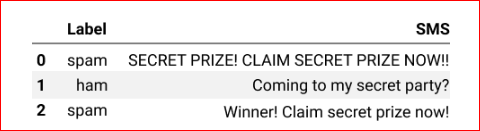

To make the calculations easier, we want bring the data to this format (the table below is a transformation of the table we see above):

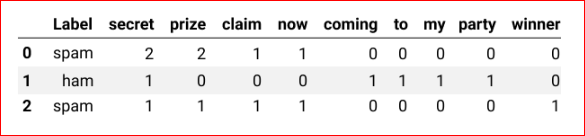

About the transformation above, notice that:

* The SMS column doesn't exist anymore.
* Instead, the SMS column is replaced by a series of new columns, where each column represents a unique word from the vocabulary.
* Each row describes a single message. For instance, the first row corresponds to the message "SECRET PRIZE! CLAIM SECRET PRIZE NOW!!", and it has the values spam, 2, 2, 1, 1, 0, 0, 0, 0, 0. These values tell us that:
 * The message is spam.
 * The word "secret" occurs two times inside the message.
 * The word "prize" occurs two times inside the message.
 * The word "claim" occurs one time inside the message.
 * The word "now" occurs one time inside the message.
 * The words "coming", "to", "my", "party", and "winner" occur zero times inside the message.
 * All words in the vocabulary are in lower case, so "SECRET" and "secret" come to be considered to be the same word.
* Punctuation is not taken into account anymore (for instance, we can't look at the table and conclude that the first message initially had three exclamation marks).

We'll begin with removing all the punctuation and bringing every letter to lower case.

In [37]:
# Before cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [38]:
# After cleaning
training_set["SMS"] = training_set["SMS"].str.replace("\W", " ").str.lower()

training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


our end goal with this data cleaning process is to bring our training set to this format:

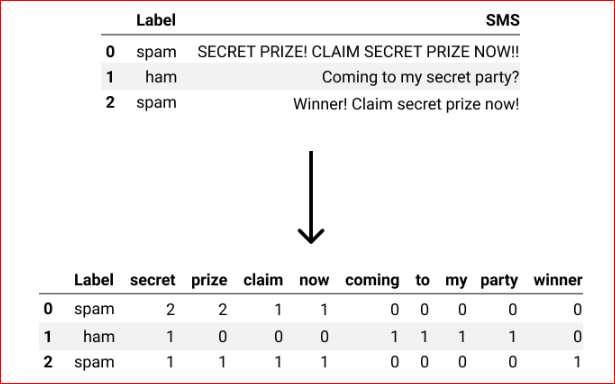

With the exception of the "Label" column, every other column in the transformed table above represents a unique word in our vocabulary (more specifically, each column shows the frequency of that unique word for any given message-----we call the set of unique words a vocabulary).

We'll eventually bring the training set to that format ourselves, but first, let's create a list with all of the unique words that occur in the messages of our training set.

In [39]:
training_set["SMS"] = training_set["SMS"].str.split()

training_set["SMS"].head()

0                    [yep, by, the, pretty, sculpture]
1    [yes, princess, are, you, going, to, make, me,...
2                      [welp, apparently, he, retired]
3                                             [havent]
4    [i, forgot, 2, ask, ü, all, smth, there, s, a,...
Name: SMS, dtype: object

In [40]:
vocabulary = []
for item in training_set["SMS"]:
    for word in item:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))
len(vocabulary)      

7783

It looks like there are 7,783 unique words in all the messages of our training set.

To create the dictionary we need for our training set, we can use the code below, where:

We start by initializing a dictionary named word_counts_per_sms, where each key is a unique word (a string) from the vocabulary, and each value is a list of the length of training set, where each element in the list is a 0

In [41]:
# word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary} or

word_counts_per_sms = {}

for i in vocabulary:
    word_counts_per_sms[i] = [0]*len(training_set)


In [42]:
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1
        
    

In [43]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,tasts,defo,degrees,rum,lipo,relation,poking,greeting,ignorant,cool,...,hahaha,breaking,spam,ago,contacted,pobox365o4w45wq,tolerat,contacts,cooked,elliot
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
training_set_clean = pd.concat([training_set, word_counts], axis = 1)
training_set_clean.head()

,Label,SMS,tasts,defo,degrees,rum,lipo,relation,poking,greeting,...,hahaha,breaking,spam,ago,contacted,pobox365o4w45wq,tolerat,contacts,cooked,elliot
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we're done with data cleaning and have a training set to work with, we can begin creating the spam filter. Recall that the Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages:

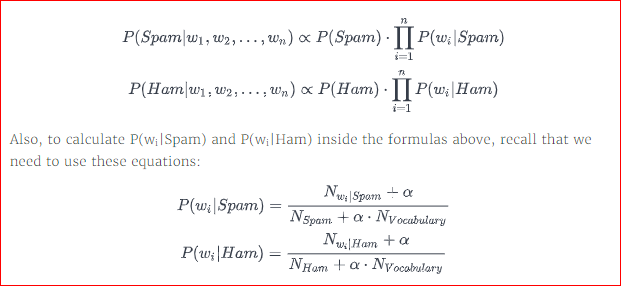

Some of the terms in the four equations above will have the same value for every new message. As a start, let's first calculate:

* *P(Spam) and P(Ham)*
* $N_Spam$, $N_Ham$, $N_Vocabulary$

* NSpam is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
* NHam is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.



In [57]:
# P(Spam) and P(Ham)
p_spam = training_set_clean['Label'].value_counts(normalize=True)['spam']
p_ham = training_set_clean['Label'].value_counts(normalize=True)['ham']

# N_Spam, N_Ham, and N_Vocabulary
n_spam = training_set_clean[training_set_clean['Label'] == 'spam'].sum(
                                                    axis=1).sum()
n_ham = training_set_clean[training_set_clean['Label'] == 'ham'].sum(
                                                    axis=1).sum()
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

As we've already mentioned, all above terms will have constant values in our equations for every new message (regardless of the message or each individual word in the message).

However, P(wi|Spam) and P(wi|Ham) will vary depending on the individual words. For instance, P("secret"|Spam) will have a certain probability value, while P("cousin"|Spam) or P("lovely"|Spam) will most likely have other values.

Although both P(wi|Spam) and P(wi|Ham) vary depending on the word, the probability for each individual word is constant for every new message.

We have 7,783 words in our vocabulary, which means we'll need to calculate a total of 15,566 probabilities. For each word, we need to calculate both P(wi|Spam) and P(wi|Ham)

In more technical language, the probability values that P(wi|Spam) and P(wi|Ham) will take are called **parameters**.

In [58]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Isolate spam and ham messages before starting the loop below
# Don't do this inside the loop, it'll add to code running time significantly
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter. The spam filter can be understood as a function that:

* Takes in as input a new message (w1, w2, ..., wn)
* Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn)
* Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
 * If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
 * If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
 * If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

Note that some new messages will contain words that are not part of the vocabulary. We simply ignore these words when we're calculating the probabilities.

In [65]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        return 'Label: Ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'Label: Spam'
    else:
        return 'Equal proabilities, have a human classify this!'

#  classify two new messages

In [66]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27


'Label: Spam'

In [67]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21


'Label: Ham'

In [76]:
# removing print statement from classify function
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'Equal proabilities, have a human classify this!'

In [77]:
test_set["predicted"] = test_set["SMS"].apply(classify)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use **accuracy** as a metric:

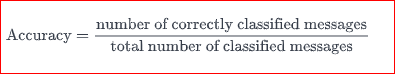

In [83]:
correct = 0
total_messages = 0
for index, row in test_set.iterrows():
    total_messages += 1
    if row["Label"] == row["predicted"]:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total_messages - correct)
print('Accuracy:', correct/total_messages)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The accuracy is close to 98.74%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

# Next Steps

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that.

Next steps include:

* Analyze the 14 messages that were classified incorrectly and try to figure out why the algorithm classified them incorrectly
* Make the filtering process more complex by making the algorithm sensitive to letter case